In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import pickle
import seaborn as sns

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

In [2]:
# Load your power consumption data into a Pandas DataFrame
df = pd.read_csv('energy_weather_raw_data.csv', parse_dates=True)
df.date = pd.to_datetime(df.date, format='%Y-%m-%d %H:%M:%S')
df = df.drop(columns=['temp_t+1', 'feels_like_t+1'])

## Basic data manipulation

In [3]:
df.isna().sum()

date              0
active_power      0
current           0
voltage           0
reactive_power    0
apparent_power    0
power_factor      0
main              0
description       0
temp              0
feels_like        0
temp_min          0
temp_max          0
pressure          0
humidity          0
speed             0
deg               0
dtype: int64

In [4]:
df.dtypes

date              datetime64[ns]
active_power             float64
current                  float64
voltage                  float64
reactive_power           float64
apparent_power           float64
power_factor             float64
main                      object
description               object
temp                     float64
feels_like               float64
temp_min                 float64
temp_max                 float64
pressure                   int64
humidity                   int64
speed                    float64
deg                        int64
dtype: object

In [5]:
df['main'].unique().tolist()

['Clear', 'Mist', 'Clouds', 'Haze', 'Fog', 'Drizzle', 'Rain', 'Thunderstorm']

In [6]:
df['description'].unique().tolist()

['clear sky',
 'mist',
 'few clouds',
 'scattered clouds',
 'broken clouds',
 'overcast clouds',
 'haze',
 'fog',
 'light intensity drizzle',
 'light rain',
 'moderate rain',
 'thunderstorm',
 'heavy intensity rain',
 'very heavy rain',
 'thunderstorm with rain',
 'drizzle']

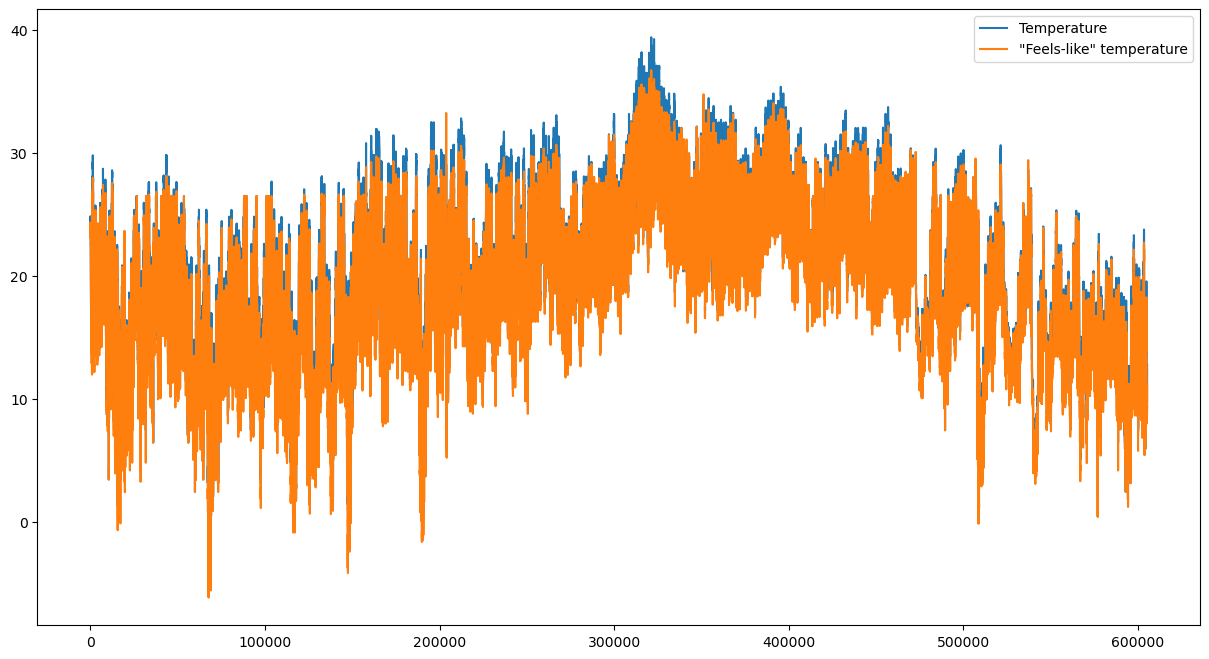

In [7]:
fig = plt.figure(figsize=(15, 8)) 

df['temp'].plot(label='Temperature')
df['feels_like'].plot(label='"Feels-like" temperature')

plt.legend()
plt.show()

In [8]:
cat_cols = ['main', 'description']

for c in cat_cols:
    df[c] = pd.Categorical(df[c])
    df[c+'_cat'] = df[c].astype('category').cat.codes

## EDA

<Axes: >

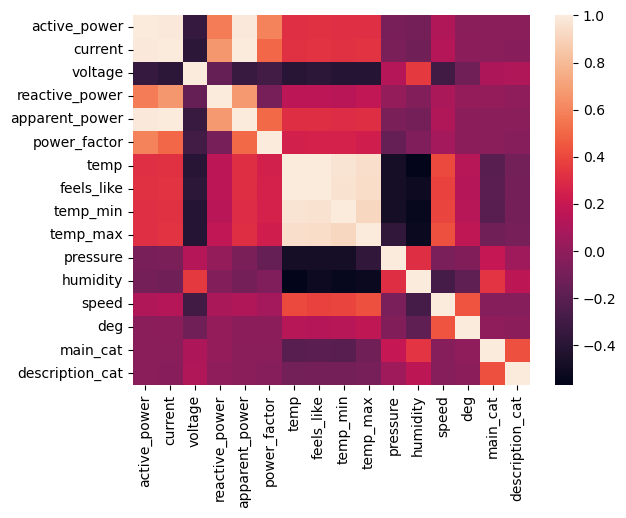

In [9]:
# plot the correlation heatmap
sns.heatmap(df.corr(numeric_only=True))

<Axes: >

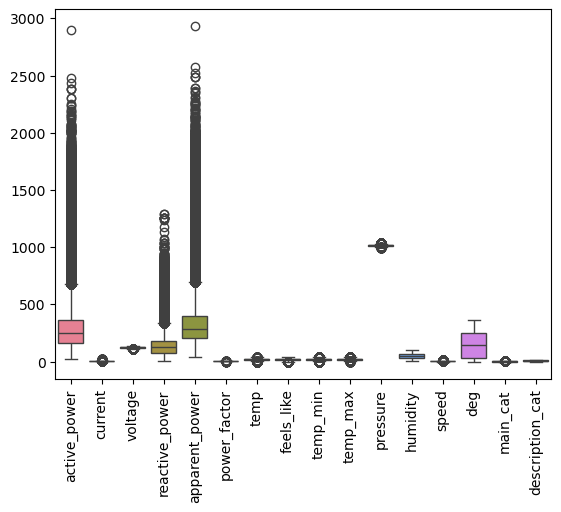

In [10]:
plt.xticks(rotation=90)
sns.boxplot(data=df.drop(columns=['date']))

In [11]:
# Calculate mean active for each month at 00:00:00
def mean_active_at_time(df, time):
    return df[df.date.dt.strftime('%H:%M:%S') == time]['active_power'].mean()

mean_active_per_month = df.groupby(df.date.dt.month).apply(mean_active_at_time, time='00:00:00')

print("Mean Global active power for each month at 00:00")
print(mean_active_per_month)

Mean Global active power for each month at 00:00
date
1     198.541667
2     257.485714
3     243.132258
4     225.140000
5     315.545161
6     477.203333
7     465.616667
8     403.145161
9     333.055172
10    288.345161
11    207.872727
12    233.275806
dtype: float64


In [12]:
print('Main column unique values:')
print(df['main'].unique().tolist())

print()

print('Description column unique values:')
print(df['description'].unique().tolist())

Main column unique values:
['Clear', 'Mist', 'Clouds', 'Haze', 'Fog', 'Drizzle', 'Rain', 'Thunderstorm']

Description column unique values:
['clear sky', 'mist', 'few clouds', 'scattered clouds', 'broken clouds', 'overcast clouds', 'haze', 'fog', 'light intensity drizzle', 'light rain', 'moderate rain', 'thunderstorm', 'heavy intensity rain', 'very heavy rain', 'thunderstorm with rain', 'drizzle']


In [13]:
df = df.drop(columns=['main_cat', 'description_cat'])

cat_cols = ['main']
category_mapping = {}

for c in cat_cols:
    df[c] = pd.Categorical(df[c])
    category_mapping.update(dict(zip(df[c], df[c].cat.codes)))
    df[c] = df[c].astype('category').cat.codes

for c in ['description']:
    df[c] = pd.Categorical(df[c])
    df[c] = df[c].astype('category').cat.codes

category_mapping.update({k.lower(): v for k, v in category_mapping.items()})
category_mapping.update({k.upper(): v for k, v in category_mapping.items()})

category_mapping

{'Clear': 0,
 'Mist': 5,
 'Clouds': 1,
 'Haze': 4,
 'Fog': 3,
 'Drizzle': 2,
 'Rain': 6,
 'Thunderstorm': 7,
 'clear': 0,
 'mist': 5,
 'clouds': 1,
 'haze': 4,
 'fog': 3,
 'drizzle': 2,
 'rain': 6,
 'thunderstorm': 7,
 'CLEAR': 0,
 'MIST': 5,
 'CLOUDS': 1,
 'HAZE': 4,
 'FOG': 3,
 'DRIZZLE': 2,
 'RAIN': 6,
 'THUNDERSTORM': 7}

In [14]:
# Store categorical to numerical mapping
with open('category_mapping.pkl', 'wb') as fout:
    pickle.dump(category_mapping, fout)

## Time series analysis

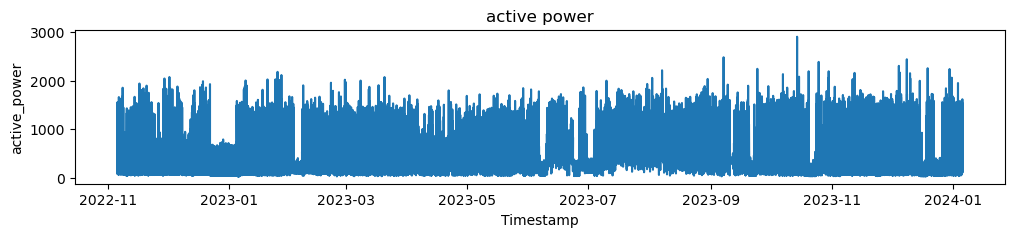

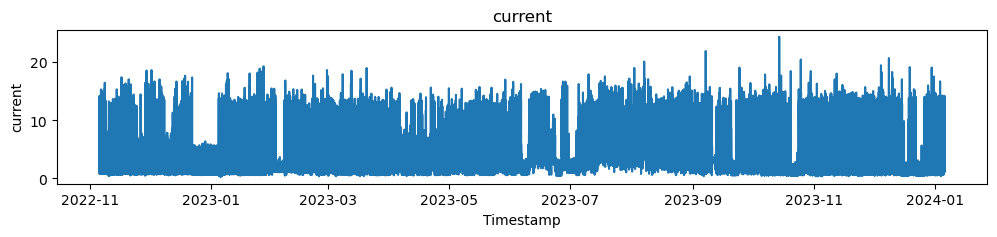

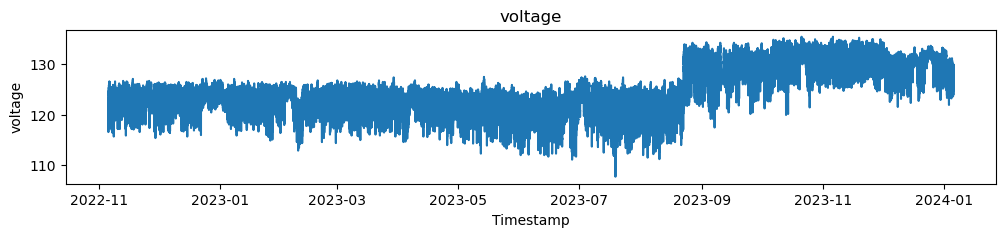

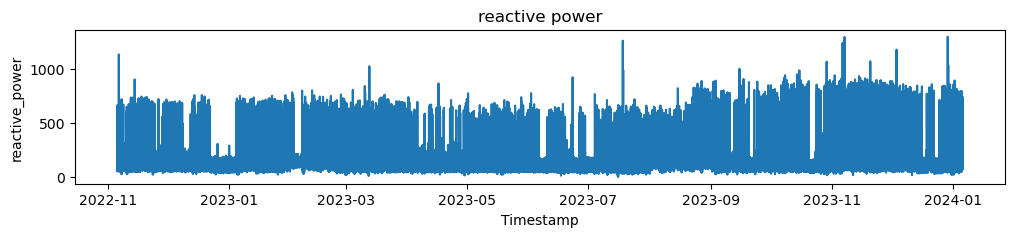

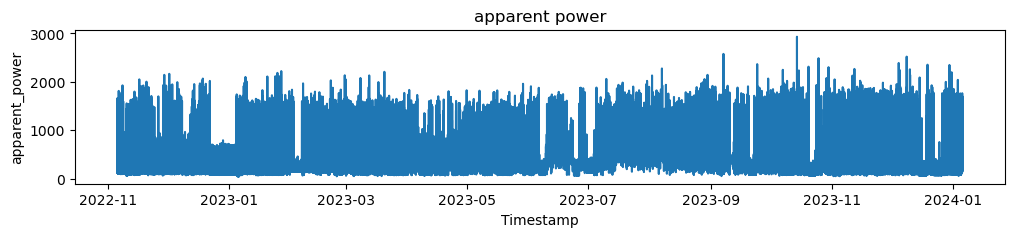

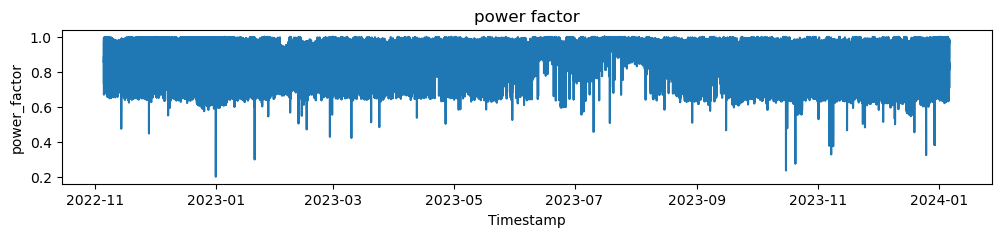

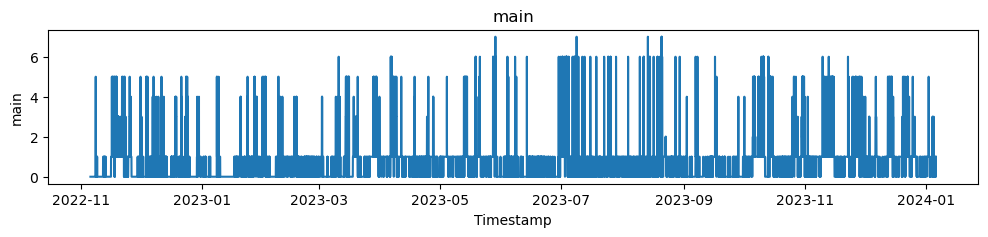

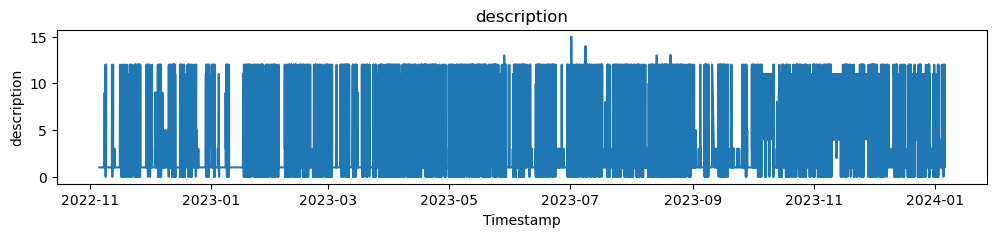

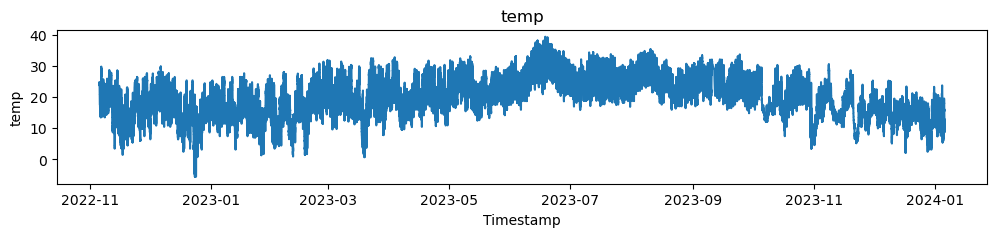

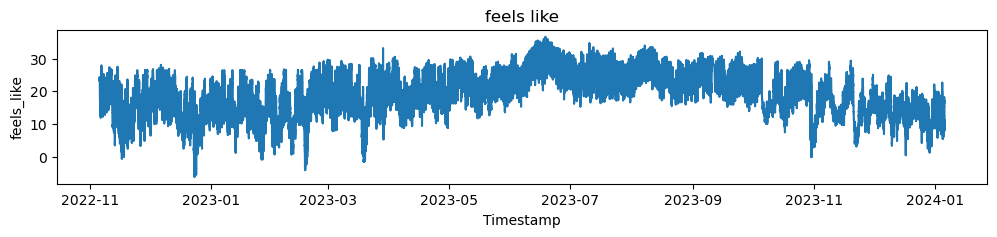

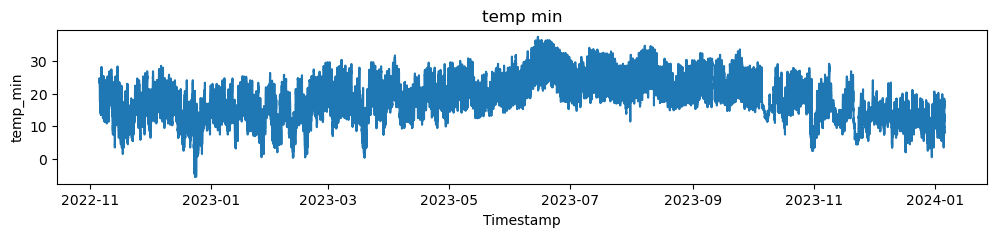

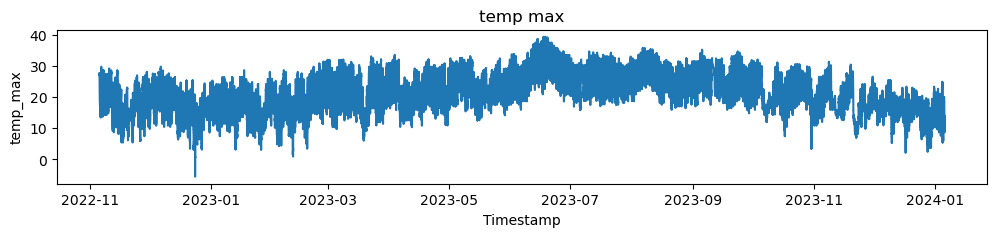

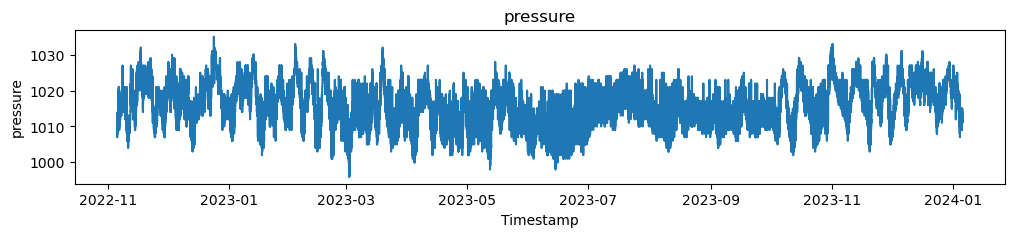

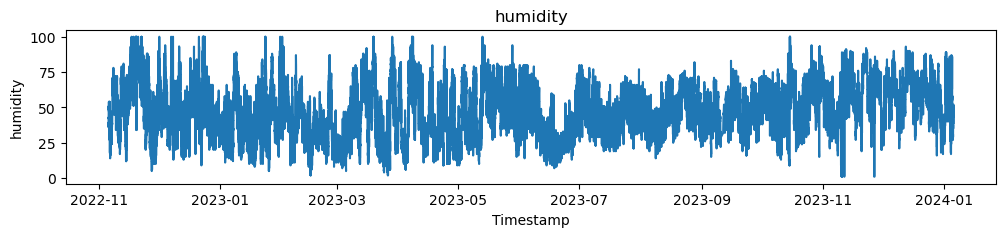

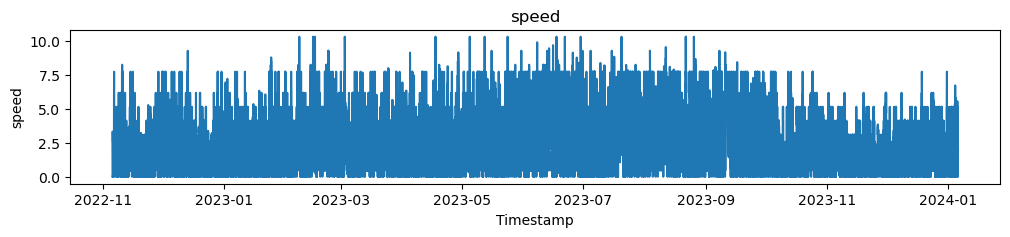

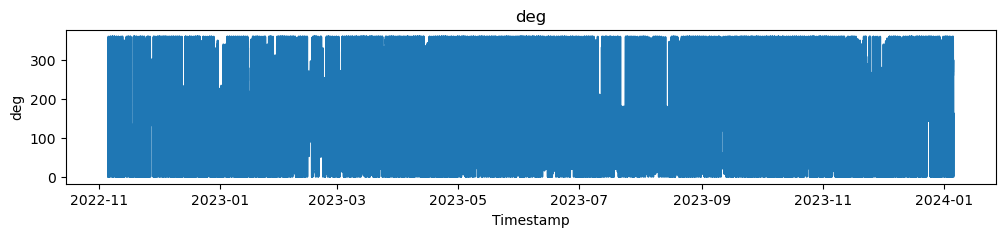

In [15]:
# Visualize the data to understand its patterns
for c in df.drop(columns=['date']).columns:
    plt.figure(figsize=(12, 2))
    plt.plot(df['date'], df[c])
    plt.title(' '.join(c.split('_')))
    plt.xlabel('Timestamp')
    plt.ylabel(c)
    plt.show()

In [16]:
average_power_per_month = df.groupby(df['date'].dt.month)['active_power'].mean()

highest_power_month = average_power_per_month.idxmax()  # idxmax() returns the index of the maximum value

highest_power_reading = df[df['date'].dt.month == highest_power_month]['active_power'].max()

print("Month with the highest average active power:", highest_power_month)
print("Highest active power reading for this month:", highest_power_reading)

Month with the highest average active power: 7
Highest active power reading for this month: 1997.1


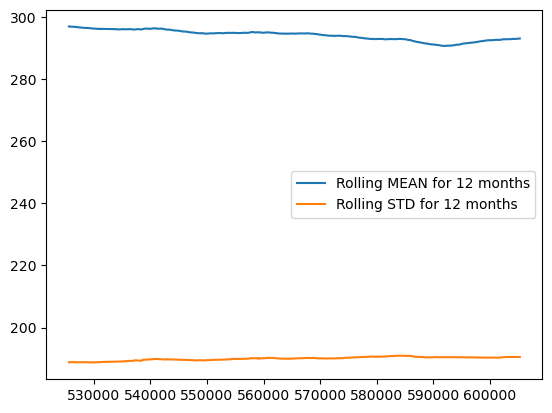

In [17]:
window = 365*24*60
df['active_power'].rolling(window=window).mean().plot(label='Rolling MEAN for 12 months')
df['active_power'].rolling(window=window).std().plot(label='Rolling STD for 12 months')
plt.legend()
plt.show()

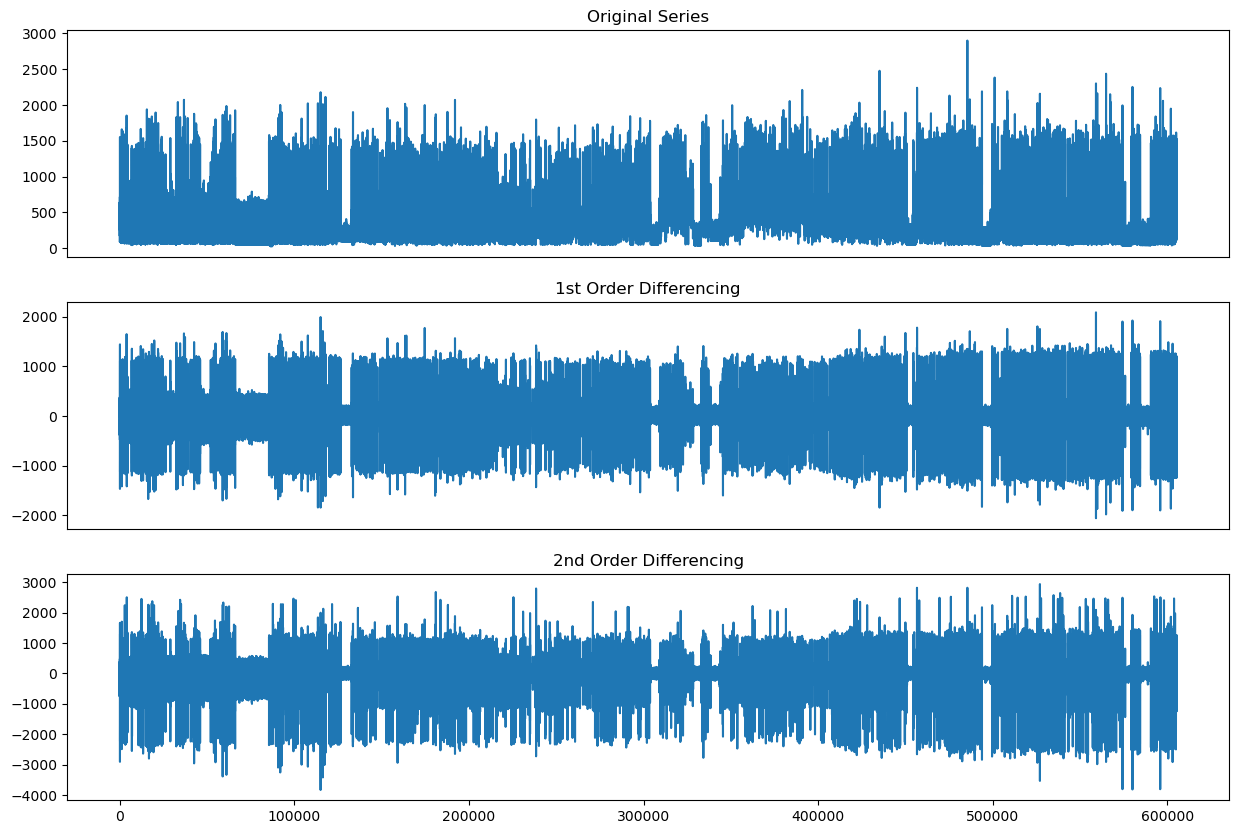

In [18]:
# Original Series
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(15, 10))
ax1.plot(df['active_power'].dropna()); ax1.set_title('Original Series'); ax1.axes.xaxis.set_visible(False)
# 1st Differencing
ax2.plot(df['active_power'].diff().dropna()); ax2.set_title('1st Order Differencing'); ax2.axes.xaxis.set_visible(False)
# 2nd Differencing
ax3.plot(df['active_power'].diff().diff().dropna()); ax3.set_title('2nd Order Differencing')
plt.show()

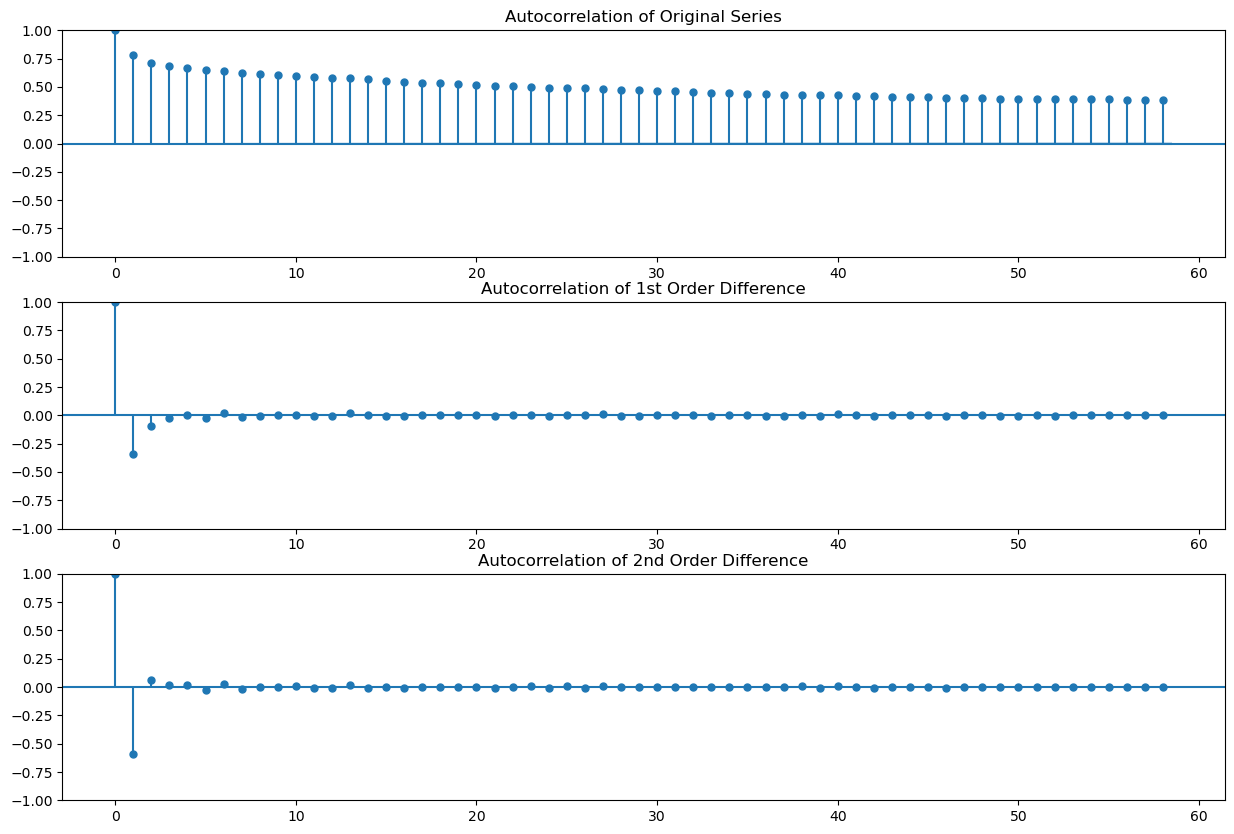

In [19]:
# Plot ACF

fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(15, 10))

plot_acf(df['active_power'].dropna(), ax=ax1, title='Autocorrelation of Original Series', )
plot_acf(df['active_power'].diff().dropna(), ax=ax2, title='Autocorrelation of 1st Order Difference', )
plot_acf(df['active_power'].diff().diff().dropna(), ax=ax3, title='Autocorrelation of 2nd Order Difference', )

plt.show()

# So, d<2, q<3

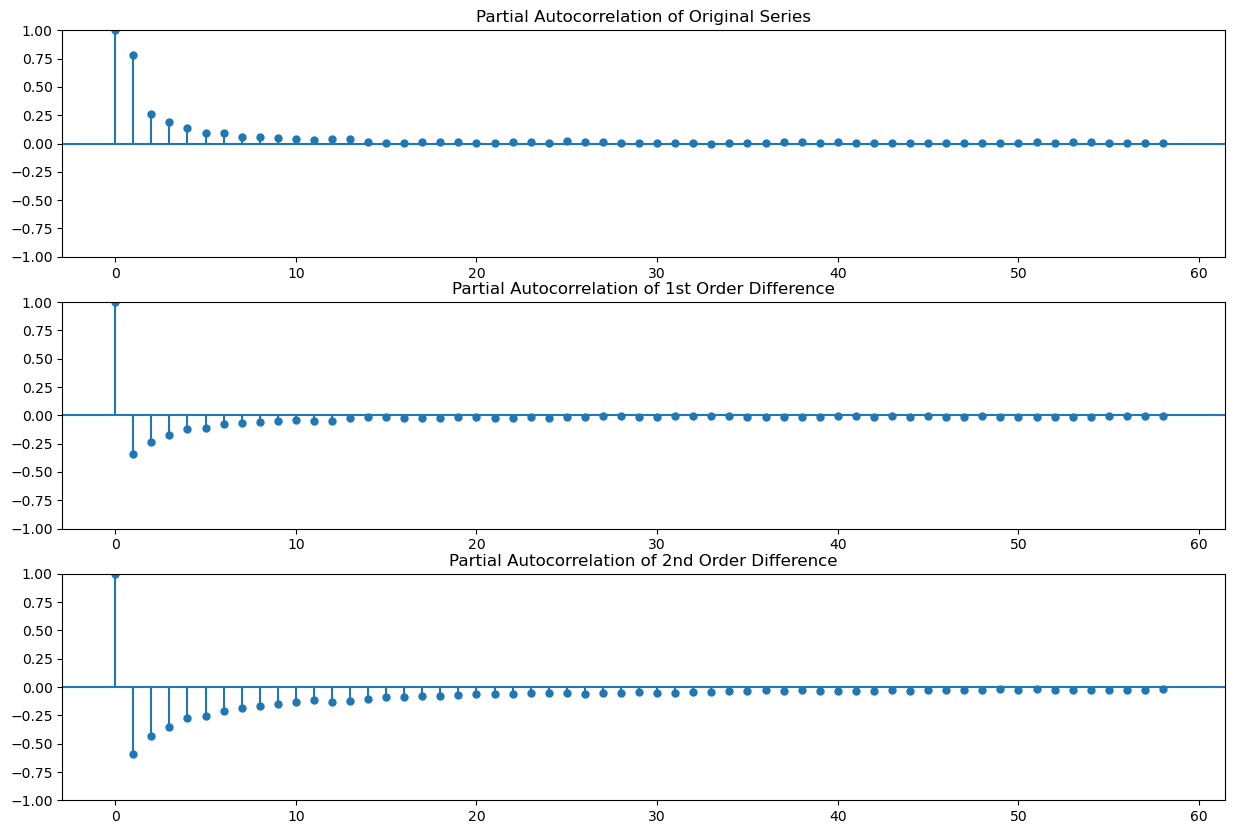

In [20]:
# Plot PACF

fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(15, 10))

plot_pacf(df['active_power'].dropna(), ax=ax1, title='Partial Autocorrelation of Original Series', )
plot_pacf(df['active_power'].diff().dropna(), ax=ax2, title='Partial Autocorrelation of 1st Order Difference', )
plot_pacf(df['active_power'].diff().diff().dropna(), ax=ax3, title='Partial Autocorrelation of 2nd Order Difference', )

plt.show()

# So, p<2